In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext, ROUND_HALF_UP
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import cm
from scipy import stats
import statsmodels.formula.api as smf
import patsy

# Fig. 6a

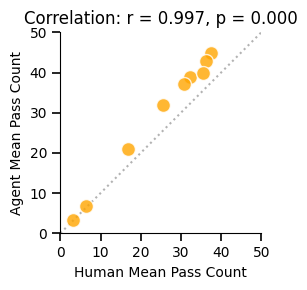

In [2]:

alphabets = list("ABCDEFGHI")  # A〜I

# human
pass_matrix = []
for alphabet_num in range(9):
    
    pass_count_end_episode_sub = []
    for sub_num in range(28):
        
        pass_count_end_episode = []
        for con_num in range(3):
            con_alphabet = alphabets[alphabet_num]
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)
            load_name = f"../data/sub/sub{sub}/sub{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):
                pos_episode = pos_list[episode]
                pass_times_episode = pos_episode[7]
                pass_count_end_episode.append(pass_times_episode[-1])

        pass_count_end_episode_sub.append(np.mean(pass_count_end_episode))
            
    pass_matrix.append(pass_count_end_episode_sub)

pass_matrix = np.array(pass_matrix).reshape(3, 3, 28)
mean_matrix = pass_matrix.mean(axis=2)


# agent
agent_pass_matrix = []
for alphabet_num in range(9):
    
    pass_count_end_episode_sub = []
    for sub_num in range(28):
        
        pass_count_end_episode = []
        for con_num in range(3):
            con_alphabet = alphabets[alphabet_num]
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)
            load_name = f"../data/agent/max_sigma_human/max_20/sigma_32/agent{sub}/agent{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)

            for episode in range(8):
                pos_episode = pos_list[episode]
                pass_times_episode = pos_episode[7]
                pass_count_end_episode.append(pass_times_episode[-1])

        pass_count_end_episode_sub.append(np.mean(pass_count_end_episode))

    agent_pass_matrix.append(pass_count_end_episode_sub)

agent_pass_matrix = np.array(agent_pass_matrix).reshape(3, 3, 28)
agent_mean_matrix = agent_pass_matrix.mean(axis=2)


# plot
human_vals = np.array(mean_matrix).flatten()
agent_vals = np.array(agent_mean_matrix).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0, 50], [0, 50], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color='orange', edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Human Mean Pass Count")
ax.set_ylabel("Agent Mean Pass Count")
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()
plt.show()



# Fig. 6b-d

In [3]:
def initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode, threshold=1e-2):
    dist_now_1 = np.linalg.norm(attacker1_pos_episode[0] - ball_pos_episode[0])
    dist_now_2 = np.linalg.norm(attacker2_pos_episode[0] - ball_pos_episode[0])
    dist_now_3 = np.linalg.norm(attacker3_pos_episode[0] - ball_pos_episode[0])
    
    if dist_now_1 > threshold and dist_now_2 > threshold and dist_now_3 > threshold:
        if dist_now_1 < dist_now_2 and dist_now_1 < dist_now_3:
            pass_outcome_a1 = 1
            pass_outcome_a2 = 0
            pass_outcome_a3 = 0
        elif dist_now_2 < dist_now_1 and dist_now_2 < dist_now_3:
            pass_outcome_a1 = 0
            pass_outcome_a2 = 1
            pass_outcome_a3 = 0
        elif dist_now_3 < dist_now_1 and dist_now_3 < dist_now_2:
            pass_outcome_a1 = 0
            pass_outcome_a2 = 0
            pass_outcome_a3 = 1
    
    else:
        pass_outcome_a1 = 0
        pass_outcome_a2 = 0
        pass_outcome_a3 = 0

    return pass_outcome_a1, pass_outcome_a2, pass_outcome_a3


def last_pass_check(defender_pos_episode, ball_pos_episode, threshold=1e-2):
    dist_now = np.linalg.norm(defender_pos_episode[-1] - ball_pos_episode[-1])
    
    if dist_now < threshold:
        last_pass = 0
    else:
        last_pass = 1

    return last_pass


def get_last_pass_index(pass_outcome):
    try:
        return len(pass_outcome) - 1 - pass_outcome[::-1].index(1)
    except ValueError:
        return -1


In [4]:

all_pass_rate_a1 = []
all_pass_rate_a2 = []
all_pass_rate_a3 = []

for sub_num in range(28):

    pass_rate_a1 = []
    pass_rate_a2 = []
    pass_rate_a3 = []

    for alphabet_num in range(len(alphabets)):

        pass_outcome_a1 = []
        pass_outcome_a2 = []
        pass_outcome_a3 = []

        for con_num in range(3):

            con_alphabet = alphabets[alphabet_num]       
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)  
            load_name = "../data/sub/sub" + sub + "/sub" + sub + "_" + condition + ".npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):

                pass_episode_a1 = []
                pass_episode_a2 = []
                pass_episode_a3 = []
                
                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode = pos_episode[4]

                pass_a1, pass_a2, pass_a3 = initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode)
                pass_episode_a1.append(pass_a1)
                pass_episode_a2.append(pass_a2)
                pass_episode_a3.append(pass_a3)
                
                if pass_a1==1:
                    pass_outcome_a1.append(pass_a1)
                elif pass_a2:
                    pass_outcome_a2.append(pass_a2)
                elif pass_a3:
                    pass_outcome_a3.append(pass_a3)
                
                threshold = 1e-2
                for t in range(len(defender_pos_episode) - 1):                
                    
                    # attacker1
                    dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                    dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])
                    
                    if dist_now_1 < threshold and dist_next_1 >= threshold:
                        pass_episode_a1.append(1)
                        pass_outcome_a1.append(1)
                    else:
                        pass_episode_a1.append(0)

                    # attacker2
                    dist_now_2 = np.linalg.norm(attacker2_pos_episode[t] - ball_pos_episode[t])
                    dist_next_2 = np.linalg.norm(attacker2_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_2 < threshold and dist_next_2 >= threshold:
                        pass_episode_a2.append(1)
                        pass_outcome_a2.append(1)
                    else:
                        pass_episode_a2.append(0)
                            
                    # attacker3
                    dist_now_3 = np.linalg.norm(attacker3_pos_episode[t] - ball_pos_episode[t])
                    dist_next_3 = np.linalg.norm(attacker3_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_3 < threshold and dist_next_3 >= threshold:
                        pass_episode_a3.append(1)
                        pass_outcome_a3.append(1)
                    else:
                        pass_episode_a3.append(0)
                    
                last_pass = last_pass_check(defender_pos_episode, ball_pos_episode)                 
                dist_next_b = np.linalg.norm(ball_pos_episode[-1] - np.array([0, 0]))
                if last_pass == 0 or dist_next_b >= 0.8:
                    
                    idx_a1 = get_last_pass_index(pass_episode_a1)
                    idx_a2 = get_last_pass_index(pass_episode_a2)
                    idx_a3 = get_last_pass_index(pass_episode_a3)

                    last_idx = max(idx_a1, idx_a2, idx_a3)

                    if last_idx == idx_a1:
                        last_passer = "a1"
                    elif last_idx == idx_a2:
                        last_passer = "a2"
                    elif last_idx == idx_a3:
                        last_passer = "a3"
                    else:
                        last_passer = "none"
                        
                    if last_passer == "a1":
                        pass_outcome_a1[-1] = 0
                    elif last_passer == "a2":
                        pass_outcome_a2[-1] = 0
                    elif last_passer == "a3":
                        pass_outcome_a3[-1] = 0

        pass_rate_a1.append(np.mean(pass_outcome_a1))
        pass_rate_a2.append(np.mean(pass_outcome_a2))
        pass_rate_a3.append(np.mean(pass_outcome_a3))

    all_pass_rate_a1.append(pass_rate_a1)
    all_pass_rate_a2.append(pass_rate_a2)
    all_pass_rate_a3.append(pass_rate_a3)

all_pass_rate_a1 = np.array(all_pass_rate_a1).T
all_pass_rate_a2 = np.array(all_pass_rate_a2).T
all_pass_rate_a3 = np.array(all_pass_rate_a3).T

print("Finish!")

Finish!


In [5]:

all_pass_rate_a1_agent = []
all_pass_rate_a2_agent = []
all_pass_rate_a3_agent = []

for sub_num in range(28):

    pass_rate_a1 = []
    pass_rate_a2 = []
    pass_rate_a3 = []

    for alphabet_num in range(len(alphabets)):

        pass_outcome_a1 = []
        pass_outcome_a2 = []
        pass_outcome_a3 = []

        for con_num in range(3):

            con_alphabet = alphabets[alphabet_num]       
            sub = '{0:03d}'.format(sub_num + 1)
            condition = con_alphabet + str(con_num + 1)
            
            load_name = f"../data/agent/max_sigma_human/max_20/sigma_32/agent{sub}/agent{sub}_{condition}.npy"
            pos_list = np.load(load_name, allow_pickle=True)
            
            for episode in range(8):

                pass_episode_a1 = []
                pass_episode_a2 = []
                pass_episode_a3 = []
                
                pos_episode = pos_list[episode]
                defender_pos_episode = pos_episode[0]
                attacker1_pos_episode = pos_episode[1]
                attacker2_pos_episode = pos_episode[2]
                attacker3_pos_episode = pos_episode[3]
                ball_pos_episode = pos_episode[4]

                pass_a1, pass_a2, pass_a3 = initial_pass_check(attacker1_pos_episode, attacker2_pos_episode, attacker3_pos_episode, ball_pos_episode)
                pass_episode_a1.append(pass_a1)
                pass_episode_a2.append(pass_a2)
                pass_episode_a3.append(pass_a3)
                
                if pass_a1==1:
                    pass_outcome_a1.append(pass_a1)
                elif pass_a2:
                    pass_outcome_a2.append(pass_a2)
                elif pass_a3:
                    pass_outcome_a3.append(pass_a3)
                
                threshold = 1e-2
                for t in range(len(defender_pos_episode) - 1):                
                    
                    # attacker1
                    dist_now_1 = np.linalg.norm(attacker1_pos_episode[t] - ball_pos_episode[t])
                    dist_next_1 = np.linalg.norm(attacker1_pos_episode[t+1] - ball_pos_episode[t+1])
                    
                    if dist_now_1 < threshold and dist_next_1 >= threshold:
                        pass_episode_a1.append(1)
                        pass_outcome_a1.append(1)
                    else:
                        pass_episode_a1.append(0)

                    # attacker2
                    dist_now_2 = np.linalg.norm(attacker2_pos_episode[t] - ball_pos_episode[t])
                    dist_next_2 = np.linalg.norm(attacker2_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_2 < threshold and dist_next_2 >= threshold:
                        pass_episode_a2.append(1)
                        pass_outcome_a2.append(1)
                    else:
                        pass_episode_a2.append(0)
                            
                    # attacker3
                    dist_now_3 = np.linalg.norm(attacker3_pos_episode[t] - ball_pos_episode[t])
                    dist_next_3 = np.linalg.norm(attacker3_pos_episode[t+1] - ball_pos_episode[t+1])
                    if dist_now_3 < threshold and dist_next_3 >= threshold:
                        pass_episode_a3.append(1)
                        pass_outcome_a3.append(1)
                    else:
                        pass_episode_a3.append(0)
                    
                last_pass = last_pass_check(defender_pos_episode, ball_pos_episode)                 
                dist_next_b = np.linalg.norm(ball_pos_episode[-1] - np.array([0, 0]))
                if last_pass == 0 or dist_next_b >= 0.8:
                    
                    idx_a1 = get_last_pass_index(pass_episode_a1)
                    idx_a2 = get_last_pass_index(pass_episode_a2)
                    idx_a3 = get_last_pass_index(pass_episode_a3)

                    last_idx = max(idx_a1, idx_a2, idx_a3)

                    if last_idx == idx_a1:
                        last_passer = "a1"
                    elif last_idx == idx_a2:
                        last_passer = "a2"
                    elif last_idx == idx_a3:
                        last_passer = "a3"
                    else:
                        last_passer = "none"  # 誰もパスしていない場合
                        
                    if last_passer == "a1":
                        pass_outcome_a1[-1] = 0
                    elif last_passer == "a2":
                        pass_outcome_a2[-1] = 0
                    elif last_passer == "a3":
                        pass_outcome_a3[-1] = 0

        pass_rate_a1.append(np.mean(pass_outcome_a1))
        pass_rate_a2.append(np.mean(pass_outcome_a2))
        pass_rate_a3.append(np.mean(pass_outcome_a3))

    all_pass_rate_a1_agent.append(pass_rate_a1)
    all_pass_rate_a2_agent.append(pass_rate_a2)
    all_pass_rate_a3_agent.append(pass_rate_a3)

all_pass_rate_a1_agent = np.array(all_pass_rate_a1_agent).T
all_pass_rate_a2_agent = np.array(all_pass_rate_a2_agent).T
all_pass_rate_a3_agent = np.array(all_pass_rate_a3_agent).T

print("Finish!")

Finish!


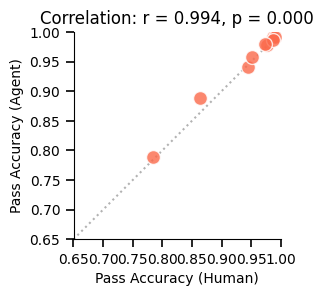

In [6]:
human_vals = np.array(all_pass_rate_a1).mean(axis=1).flatten()
agent_vals = np.array(all_pass_rate_a1_agent).mean(axis=1).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100
cmap = matplotlib.colormaps["Reds"]
color = cmap(0.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0.65, 1], [0.65, 1], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color=color, edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Pass Accuracy (Human)")
ax.set_ylabel("Pass Accuracy (Agent)")
ax.set_xlim(0.65, 1)
ax.set_ylim(0.65, 1)
ax.set_xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()

plt.show()


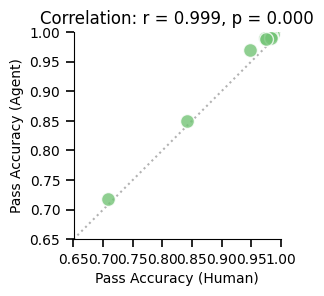

In [7]:
human_vals = np.array(all_pass_rate_a2).mean(axis=1).flatten()
agent_vals = np.array(all_pass_rate_a2_agent).mean(axis=1).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100
cmap = matplotlib.colormaps["Greens"]
color = cmap(0.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0.65, 1], [0.65, 1], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color=color, edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Pass Accuracy (Human)")
ax.set_ylabel("Pass Accuracy (Agent)")
ax.set_xlim(0.65, 1)
ax.set_ylim(0.65, 1)
ax.set_xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()

plt.show()


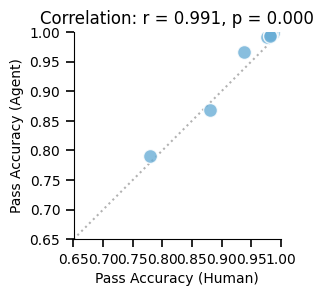

In [8]:
human_vals = np.array(all_pass_rate_a3).mean(axis=1).flatten()
agent_vals = np.array(all_pass_rate_a3_agent).mean(axis=1).flatten()

r, p = pearsonr(human_vals, agent_vals)

title_prefix="Correlation"
point_size=100
cmap = matplotlib.colormaps["Blues"]
color = cmap(0.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([0.65, 1], [0.65, 1], linestyle='dotted', color='gray', alpha=0.6, zorder=0)
ax.scatter(human_vals, agent_vals, color=color, edgecolor='white', s=point_size, zorder=1, alpha=0.8)
ax.set_xlabel("Pass Accuracy (Human)")
ax.set_ylabel("Pass Accuracy (Agent)")
ax.set_xlim(0.65, 1)
ax.set_ylim(0.65, 1)
ax.set_xticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_yticks([0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00])
ax.set_aspect('equal', adjustable='box')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.tick_params(
    axis='both', direction='out', length=6, width=1.2,
    bottom=True, top=False, left=True, right=False
)
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
ax.set_title(f"{title_prefix}: r = {r:.3f}, p = {p:.3f}")
plt.tight_layout()

plt.show()


In [9]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import patsy

# Logit transform with clipping
def logit_clip(x, eps=1e-4):
    x = np.clip(x, eps, 1 - eps)
    return np.log(x / (1 - x))

# =========================================================
# 入力：（ここを自分の配列名に置き換えるだけ）
H_a1 = np.array(all_pass_rate_a1).reshape(3, 3, 28)
H_a2 = np.array(all_pass_rate_a2).reshape(3, 3, 28)
H_a3 = np.array(all_pass_rate_a3).reshape(3, 3, 28)

A_a1 = np.array(all_pass_rate_a1_agent).reshape(3, 3, 28)
A_a2 = np.array(all_pass_rate_a2_agent).reshape(3, 3, 28)
A_a3 = np.array(all_pass_rate_a3_agent).reshape(3, 3, 28)
# =========================================================

H_logit = logit_clip(H_a3)
A_logit = logit_clip(A_a3)

# Long-format dataframe
rows = []
for b in range(3):
    for d in range(3):
        for s in range(28):
            rows.append({
                "subject": f"H{s:03d}", "group": "Human",
                "ball_lv": b, "def_lv": d,
                "pass_rate_logit": float(H_logit[b, d, s])
            })
            rows.append({
                "subject": f"A{s:03d}", "group": "Agent",
                "ball_lv": b, "def_lv": d,
                "pass_rate_logit": float(A_logit[b, d, s])
            })
df_long = pd.DataFrame(rows)

# Categorical encodings (Agent as reference)
df_long["group"]   = pd.Categorical(df_long["group"],   categories=["Agent", "Human"])
df_long["ball_lv"] = pd.Categorical(df_long["ball_lv"], categories=[0,1,2])
df_long["def_lv"]  = pd.Categorical(df_long["def_lv"],  categories=[0,1,2])

# Numeric versions for random slopes
df_long["ball_c"] = df_long["ball_lv"].astype(int)
df_long["def_c"]  = df_long["def_lv"].astype(int)

# ---- MixedLM with random slopes (1 + ball + def | subject)
fit = smf.mixedlm(
    "pass_rate_logit ~ C(group)*C(ball_lv)*C(def_lv)",
    data=df_long,
    groups=df_long["subject"],
    re_formula="~ ball_c + def_c"
).fit(method="lbfgs", maxiter=1000)

print("\n=== MixedLM (logit pass rate) with random slopes ===")
print(fit.summary())

# ---------- EMM: Agent vs Human averaged over ball×def ----------
grid = pd.DataFrame(
    [(g,b,d) for g in ["Agent","Human"] for b in [0,1,2] for d in [0,1,2]],
    columns=["group","ball_lv","def_lv"]
)
grid["group"]   = pd.Categorical(grid["group"],   categories=["Agent","Human"])
grid["ball_lv"] = pd.Categorical(grid["ball_lv"], categories=[0,1,2])
grid["def_lv"]  = pd.Categorical(grid["def_lv"],  categories=[0,1,2])

# Fixed-effect design matrix aligned to fitted model
X = patsy.dmatrix("1 + C(group)*C(ball_lv)*C(def_lv)", grid, return_type="dataframe")
beta_fe = fit.fe_params
X = X.reindex(columns=beta_fe.index, fill_value=0.0)

# FE-only predictions (logit scale)
grid["yhat_logit"] = np.dot(X.values, beta_fe.values)

# EMM: equal-weighted mean over ball×def
emm = grid.groupby("group")["yhat_logit"].mean()
emm_diff = float(emm["Agent"] - emm["Human"])

# Wald test (contrast Agent-Human)
V_all = fit.cov_params()
V_fe  = V_all.loc[beta_fe.index, beta_fe.index]
L_agent = X[grid["group"]=="Agent"].mean(axis=0).values
L_human = X[grid["group"]=="Human"].mean(axis=0).values
Ldiff   = L_agent - L_human
se = float(np.sqrt(Ldiff @ V_fe.values @ Ldiff))
z  = emm_diff / se
p  = 2 * (1 - stats.norm.cdf(abs(z)))
ci = (emm_diff - 1.96*se, emm_diff + 1.96*se)

print("\n=== EMM-based Group contrast (Agent - Human) on log-odds scale, averaged over ball×def ===")
print(f"EMM_logit(Agent) = {emm['Agent']:.2f},  EMM_logit(Human) = {emm['Human']:.2f}")
print(f"Difference (log-odds) = {emm_diff:.2f}  (95% CI {ci[0]:.2f} to {ci[1]:.2f})")
print(f"Wald z = {z:.2f},  p = {p:.4g}")

# LaTeX one-liner
p_text = "< 0.001" if p < 1e-3 else f"= {p:.3f}"
print(f"(mixed-effects model with random slopes, group $\\times$ ball $\\times$ defender; "
      f"EMM (Agent$-$Human) = {emm_diff:.2f}, 95\\% CI [{ci[0]:.2f}, {ci[1]:.2f}], Wald $z$ = {z:.2f}, $p$ {p_text}).")


/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Users/tsutsuikazushi/venv/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 15.249659
  warnings.warn(msg, ConvergenceWarning)



=== MixedLM (logit pass rate) with random slopes ===
                           Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           pass_rate_logit
No. Observations:           504               Method:                       REML           
No. Groups:                 56                Scale:                        1.3865         
Min. group size:            9                 Log-Likelihood:               -839.9978      
Max. group size:            9                 Converged:                    No             
Mean group size:            9.0                                                            
-------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------------
Intercept                                         3.4

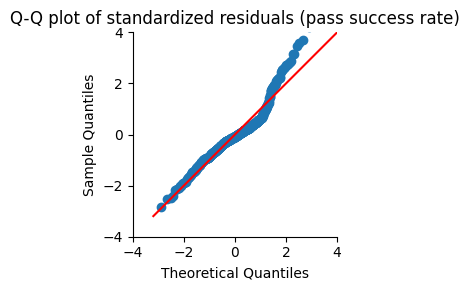

In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Standardized residuals from the fitted model
resid = fit.resid
resid_std = (resid - resid.mean()) / resid.std()

# Q-Q plot with square axes
fig, ax = plt.subplots(figsize=(3, 3))
sm.qqplot(resid_std, line='45', ax=ax)

ax.set_title("Q-Q plot of standardized residuals (pass success rate)")
ax.set_aspect('equal', 'box')  # make x and y axes the same scale
ax.set_xlim([-4, 4])
ax.set_ylim([-4, 4])
[ax.spines[side].set_visible(False) for side in ['right', 'top']]
plt.tight_layout()
plt.show()
